## Problem Statement

Wildlife conservationists and researchers need accurate predictions of animal movement patterns to prevent human-wildlife conflict, optimize conservation efforts, and track endangered species. The goal is to train an RL agent to learn optimal wildlife tracking strategies based on geospatial and environmental data.

**Key Assumptions Due to Unavailability of the required dataset and access to local dataset:**

- Rwanda's landarea is assumed to be a protected area in its entirety
- Species used in the model, are assumed to be found in Rwanda
- The dataset is a simulated dataset to showcase primarily the contributions Reinforcement Learning can make in the conservation landscape



In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from folium.plugins import HeatMap

## Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/RL/wildlife_tracking_simulated_dataset.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   species      3000 non-null   object 
 1   latitude     3000 non-null   float64
 2   longitude    3000 non-null   float64
 3   date_time    3000 non-null   object 
 4   wind_speed   3000 non-null   float64
 5   temperature  3000 non-null   float64
 6   pressure     3000 non-null   float64
 7   humidity     3000 non-null   float64
dtypes: float64(6), object(2)
memory usage: 187.6+ KB


,species,latitude,longitude,date_time,wind_speed,temperature,pressure,humidity
0,muledeer,-1.916722,30.085595,2024-09-27T00:00:00,12.283063,25.919566,1018.841862,69.458228
1,lion,-1.964521,30.022093,2024-11-06T00:00:00,7.990263,21.527403,1017.648426,62.112442
2,lion,-1.978889,30.053545,2024-12-30T00:00:00,12.190425,21.216426,1017.612551,55.200389
3,lion,-1.978352,30.029329,2025-01-29T00:00:00,2.035805,21.737211,1009.290668,61.289738
4,turkey,-1.913344,30.086157,2024-09-06T00:00:00,14.460713,29.399066,1013.500593,63.217413


In [ ]:
!pip install folium geopandas branca

## Preprocess

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Cyclical Data
df = df.sort_values("date_time")
df["datetime"] = pd.to_datetime(df["date_time"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Encode species as numerical values
species_encoder = LabelEncoder()
df["species"] = species_encoder.fit_transform(df["species"])

# # Select columns for normalization
# features_to_normalize = ["latitude", "longitude", "temperature", "humidity", "wind_speed", "pressure"]
# scaler = MinMaxScaler()
# df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Display processed data preview
df

,species,latitude,longitude,date_time,wind_speed,temperature,pressure,humidity,datetime,month,hour,hour_sin,hour_cos,month_sin,month_cos
2364,0,-1.959181,30.038481,2024-08-27T00:00:00,2.456731,20.922535,1013.522756,66.437594,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
291,5,-1.914316,30.106838,2024-08-27T00:00:00,13.520702,23.944637,1006.384212,60.560750,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
1537,2,-1.964144,30.069303,2024-08-27T00:00:00,2.103511,22.335883,1016.887667,68.785493,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
1984,3,-1.912455,30.082701,2024-08-27T00:00:00,8.427912,29.865759,1015.097772,71.739500,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
1523,5,-1.916457,30.109066,2024-08-27T00:00:00,2.699510,26.864016,1007.560208,62.770338,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,2,-1.950521,30.042956,2025-02-26T00:00:00,10.974001,20.148524,1007.348758,67.296274,2025-02-26,2,0,0.0,1.0,0.866025,0.5
1887,3,-1.939217,30.053812,2025-02-26T00:00:00,7.814374,18.052865,1005.866048,60.116690,2025-02-26,2,0,0.0,1.0,0.866025,0.5
1301,0,-1.956705,30.022095,2025-02-26T00:00:00,10.002381,23.473599,1007.047668,62.127581,2025-02-26,2,0,0.0,1.0,0.866025,0.5
2285,5,-1.915278,30.132380,2025-02-26T00:00:00,0.414735,20.612939,1018.300226,50.106930,2025-02-26,2,0,0.0,1.0,0.866025,0.5


In [ ]:
target_df = df[df["species"] == 0]

target_df

,species,latitude,longitude,date_time,wind_speed,temperature,pressure,humidity,datetime,month,hour,hour_sin,hour_cos,month_sin,month_cos
2364,0,-1.959181,30.038481,2024-08-27T00:00:00,2.456731,20.922535,1013.522756,66.437594,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
1251,0,-1.942045,30.047405,2024-08-27T00:00:00,6.280435,25.889516,1012.757096,56.273470,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
2430,0,-1.961606,30.034560,2024-08-27T00:00:00,8.801407,21.212214,1011.281055,67.058180,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
1021,0,-1.959594,30.043873,2024-08-27T00:00:00,8.439495,27.958494,1009.283704,55.909807,2024-08-27,8,0,0.0,1.0,-0.866025,-0.5
2850,0,-1.960733,30.016228,2024-08-28T00:00:00,1.305814,23.210905,1017.788336,67.836473,2024-08-28,8,0,0.0,1.0,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,0,-1.974889,30.054497,2025-02-26T00:00:00,3.726995,25.083070,1005.711463,60.604047,2025-02-26,2,0,0.0,1.0,0.866025,0.5
1212,0,-1.955572,30.061561,2025-02-26T00:00:00,2.673226,23.095783,1013.080741,60.693016,2025-02-26,2,0,0.0,1.0,0.866025,0.5
229,0,-1.956513,30.038630,2025-02-26T00:00:00,11.588055,26.455658,1018.446749,58.674920,2025-02-26,2,0,0.0,1.0,0.866025,0.5
1516,0,-1.948843,30.029243,2025-02-26T00:00:00,1.338451,27.152246,1006.106830,61.699831,2025-02-26,2,0,0.0,1.0,0.866025,0.5


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/capstone/lion/lion_migration_rwanda.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     304 non-null    object 
 1   latitude     304 non-null    float64
 2   longitude    304 non-null    float64
 3   temperature  304 non-null    float64
 4   humidity     304 non-null    float64
 5   pressure     304 non-null    float64
 6   wind_speed   304 non-null    float64
dtypes: float64(6), object(1)
memory usage: 16.8+ KB


,datetime,latitude,longitude,temperature,humidity,pressure,wind_speed
0,2024-08-01T00:00:00,-1.8160,29.0000,27.3,52.1,1021.0,5.3
1,2024-08-01T00:00:00,-2.0000,29.0525,27.0,53.9,1022.4,8.0
2,2024-08-01T00:00:00,-1.9229,29.0000,28.6,40.0,1022.0,8.0
3,2024-08-01T00:00:00,-1.8632,29.0000,29.3,48.8,1020.1,10.2
4,2024-08-01T00:00:00,-1.9369,29.0219,25.2,52.4,1017.5,13.8


<ipython-input-7-52645bbb6b68>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


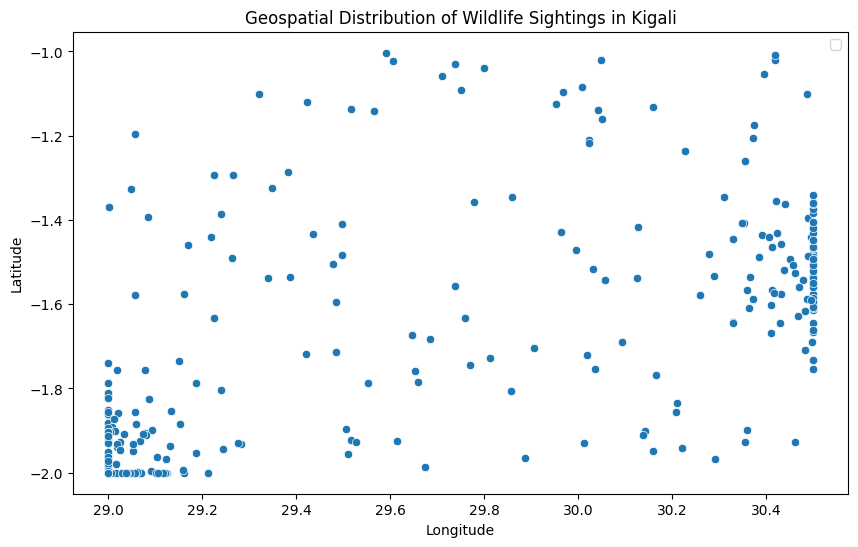

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df["longitude"], y=df["latitude"])
plt.title("Geospatial Distribution of Wildlife Sightings in Kigali")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Cyclical Data
df = df.sort_values("datetime")
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Encode species as numerical values
# species_encoder = LabelEncoder()
# df["species"] = species_encoder.fit_transform(df["species"])

# # Select columns for normalization
# features_to_normalize = ["latitude", "longitude", "temperature", "humidity", "wind_speed", "pressure"]
# scaler = MinMaxScaler()
# df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Display processed data preview
df

,datetime,latitude,longitude,temperature,humidity,pressure,wind_speed,month,hour,hour_sin,hour_cos,month_sin,month_cos
0,2024-08-01,-1.8160,29.0000,27.3,52.1,1021.0,5.3,8,0,0.0,1.0,-0.866025,-0.5
21,2024-08-01,-1.9049,29.0786,28.2,42.1,1020.4,10.3,8,0,0.0,1.0,-0.866025,-0.5
22,2024-08-01,-1.8831,29.0000,25.7,57.1,1016.5,11.2,8,0,0.0,1.0,-0.866025,-0.5
23,2024-08-01,-1.8992,29.0929,27.9,53.0,1020.6,13.9,8,0,0.0,1.0,-0.866025,-0.5
24,2024-08-01,-2.0000,29.1243,25.8,58.4,1023.5,8.9,8,0,0.0,1.0,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2025-02-27,-1.4922,30.4506,29.8,54.4,1017.0,7.7,2,0,0.0,1.0,0.866025,0.5
280,2025-02-27,-1.5948,30.5000,26.2,40.3,1019.1,13.6,2,0,0.0,1.0,0.866025,0.5
281,2025-02-27,-1.5366,30.5000,25.0,47.6,1016.7,7.6,2,0,0.0,1.0,0.866025,0.5
283,2025-02-27,-1.6082,30.3652,28.0,59.1,1018.6,11.3,2,0,0.0,1.0,0.866025,0.5


In [ ]:
from scipy.spatial import ConvexHull

<ipython-input-10-d48fafa5791f>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 12)


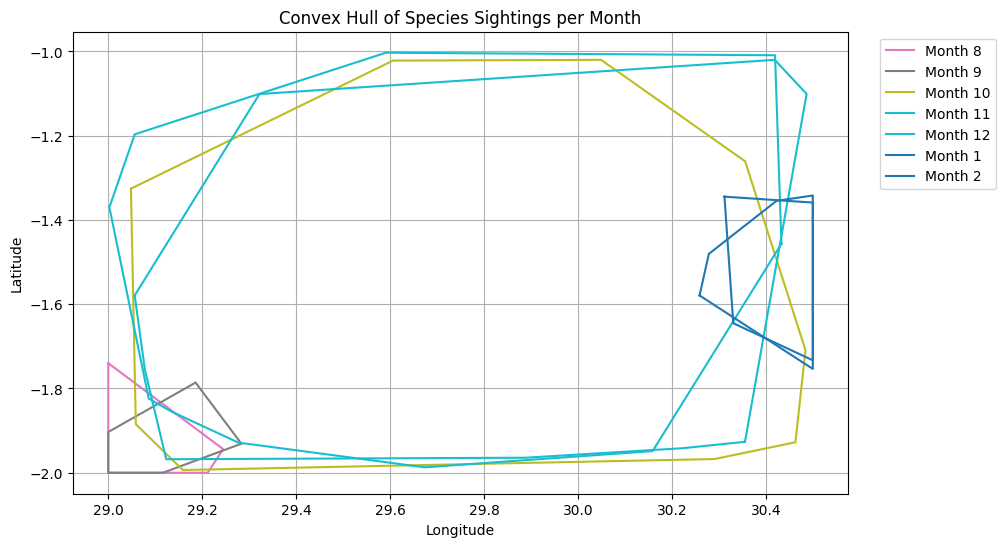

In [ ]:
plt.figure(figsize=(10, 6))

# Define colors for different months
colors = plt.cm.get_cmap("tab10", 12)

# Process each month separately
for month in df['month'].unique():
    subset = df[df['month'] == month]
    points = subset[['longitude', 'latitude']].values  # Extract lat/lon

    if len(points) >= 3:  # Convex Hull needs at least 3 points
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]

        # Draw convex hull
        plt.plot(
            np.append(hull_points[:, 0], hull_points[0, 0]),  # Closing the hull
            np.append(hull_points[:, 1], hull_points[0, 1]),
            color=colors(month - 1), label=f'Month {month}'
        )

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Convex Hull of Species Sightings per Month')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.show()

In [ ]:
import folium
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from folium.plugins import MarkerCluster
from matplotlib import cm, colors

# Load your DataFrame (df should contain 'latitude', 'longitude', and 'month' columns)
# df = pd.read_csv("your_data.csv")

# Initialize a Folium map centered on Rwanda
m = folium.Map(location=[-1.5, 29.75], zoom_start=8)

# Define colors for different months using a colormap
cmap = cm.get_cmap("tab10", 12)
norm = colors.Normalize(vmin=1, vmax=12)
month_colors = {month: colors.to_hex(cmap(norm(month))) for month in df['month'].unique()}

# Add lion movement points
marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=month_colors[row['month']],
        fill=True,
        fill_color=month_colors[row['month']],
        fill_opacity=0.6,
    ).add_to(marker_cluster)

# Overlay convex hulls per month
for month in df['month'].unique():
    subset = df[df['month'] == month]
    points = subset[['latitude', 'longitude']].values  # Extract lat/lon

    if len(points) >= 3:  # Convex Hull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_polygon = [[lat, lon] for lat, lon in hull_points]
        hull_polygon.append(hull_polygon[0])  # Close the polygon

        folium.PolyLine(
            locations=hull_polygon,
            color=month_colors[month],
            weight=2.5,
            opacity=0.8,
            tooltip=f'Month {month}'
        ).add_to(m)

# Save and display the map
m.save("lion_movement_map.html")
m

<ipython-input-3-b20409aa6882>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", 12)


NameError: name 'df' is not defined

In [ ]:
train_df = df[df["month"] != 2]

val_df = train_df[train_df["month"] == 1]

test_df = df[df["month"] == 2]

train_df.drop(columns=["date_time", "hour", "month", "datetime", "wind_speed"], inplace=True)

test_df.drop(columns=["date_time", "hour", "month", "datetime", "wind_speed"], inplace=True)

train_df

<ipython-input-32-c23807be0f6f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["date_time", "hour", "month", "datetime", "wind_speed"], inplace=True)
<ipython-input-32-c23807be0f6f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["date_time", "hour", "month", "datetime", "wind_speed"], inplace=True)


,species,latitude,longitude,temperature,pressure,humidity,hour_sin,hour_cos,month_sin,month_cos
2364,0,0.278141,0.265539,0.394558,0.568085,0.548522,0.0,1.0,-0.866025,-0.500000
291,5,0.793008,0.698609,0.596213,0.091989,0.352278,0.0,1.0,-0.866025,-0.500000
1537,2,0.221181,0.460808,0.488866,0.792503,0.626926,0.0,1.0,-0.866025,-0.500000
1984,3,0.814371,0.545690,0.991309,0.673129,0.725568,0.0,1.0,-0.866025,-0.500000
1523,5,0.768435,0.712718,0.791013,0.170421,0.426062,0.0,1.0,-0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...
2017,0,0.513275,0.076046,0.455407,0.034936,0.176315,0.0,1.0,0.500000,0.866025
1374,2,0.564398,0.232454,0.787671,0.182621,0.224682,0.0,1.0,0.500000,0.866025
2006,2,0.197917,0.366895,0.489416,0.226540,0.282152,0.0,1.0,0.500000,0.866025
1204,1,0.599280,0.482690,0.266063,0.884689,0.324736,0.0,1.0,0.500000,0.866025


In [ ]:
test_df

,species,latitude,longitude,temperature,pressure,humidity,hour_sin,hour_cos,month_sin,month_cos
561,0,0.098938,0.020446,0.451642,0.542534,0.419797,0.0,1.0,0.866025,0.5
693,4,0.643808,0.717768,0.200276,0.337929,0.657447,0.0,1.0,0.866025,0.5
2760,4,0.542271,0.829323,0.418804,0.291329,0.606107,0.0,1.0,0.866025,0.5
1993,1,0.209734,0.726466,0.330281,0.036160,0.751635,0.0,1.0,0.866025,0.5
94,0,0.374430,0.235478,0.348169,0.216285,0.371974,0.0,1.0,0.866025,0.5
...,...,...,...,...,...,...,...,...,...,...
775,2,0.377518,0.293892,0.342911,0.156318,0.577196,0.0,1.0,0.866025,0.5
1887,3,0.507243,0.362666,0.203075,0.057431,0.337449,0.0,1.0,0.866025,0.5
1301,0,0.306547,0.161730,0.564782,0.136238,0.404599,0.0,1.0,0.866025,0.5
2285,5,0.781970,0.860426,0.373900,0.886712,0.003195,0.0,1.0,0.866025,0.5


In [ ]:
# Save processed data
df.to_csv("processed_wildlife_tracking.csv", index=False)

In [ ]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

# Reinforcement Learning Framework

In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from geopy.distance import geodesic

class FootprintEnv(gym.Env):
    def __init__(self, data):
        super(FootprintEnv, self).__init__()

        self.data = data
        self.current_idx = 0
        self.max_idx = len(self.data) - 1

        # Observations: (Species ID, Weather, Time Features, Last Known Location)
        # The shape should match the number of features in _get_state()
        self.observation_space = spaces.Box(low=-1, high=1, shape=(10,), dtype=np.float32)  # Changed shape to (10,)

        # Action Space: Predict next (lat, lon)
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)

    def reset(self):
        """Reset environment to the start"""
        self.current_idx = 0
        return self._get_state()

    def _get_state(self):
        """Extracts the state at current index"""
        row = self.data.iloc[self.current_idx]
        state = np.array([
            row['species'], row['temperature'], row['pressure'], row['humidity'],
            row['hour_sin'], row['hour_cos'], row['month_sin'], row['month_cos'],
            row['latitude'], row['longitude']
        ])
        return state

    def step(self, action):
        """Takes an action (predicts next location) and computes reward"""
        if self.current_idx >= self.max_idx:
            return self._get_state(), 0, True, {}

        # Convert action to real-world coordinates
        lat_pred = action[0] * 90
        lon_pred = action[1] * 180

        # Actual next location
        next_row = self.data.iloc[self.current_idx + 1]
        actual_lat, actual_lon = next_row['latitude'], next_row['longitude']

        # Distance-based reward
        distance = geodesic((lat_pred, lon_pred), (actual_lat, actual_lon)).km
        reward = 1 / (1 + distance)  # Smaller distance = higher reward

        self.current_idx += 1
        done = self.current_idx >= self.max_idx

        return self._get_state(), reward, done, {}

In [ ]:
!pip install shimmy>=2.0

In [ ]:
# Initialize environments
train_env = FootprintEnv(train_df)
val_env = FootprintEnv(val_df)

# Initialize PPO agent
model = PPO("MlpPolicy", train_env, verbose=1)

# Train PPO with validation monitoring
for i in range(10):  # 10 training epochs
    model.learn(total_timesteps=10000)

    # Validate on month 1 data
    val_state = val_env.reset()
    val_rewards = []
    for _ in range(len(val_df)):  # Validate over month 1 data
        action, _ = model.predict(val_state)
        val_state, reward, done, _ = val_env.step(action)
        val_rewards.append(reward)
        if done:
            break

    avg_val_reward = sum(val_rewards) / len(val_rewards)
    print(f"Validation Reward (Epoch {i+1}): {avg_val_reward}")

# Save trained model
model.save("ppo_footprint_model")

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 697  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.58e+03     |
|    ep_rew_mean          | 0.282        |
| time/                   |              |
|    fps                  | 496          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0033533678 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -5.18        |
|    learning_rate        | 0.0003       |
|    los

In [ ]:
# Load trained model
model = PPO.load("ppo_footprint_model")

# Dictionary to store predictions for each species
species_predictions = {i: [] for i in range(6)}

# Loop over all species
for species_id in range(6):
    print(f"\nPredictions for Species {species_id}:")

    # Filter test data for this species
    species_df = test_df[test_df["species"] == species_id]

    # Reset environment with filtered test data
    species_env = FootprintEnv(species_df)
    state = species_env.reset()

    # Predict next locations
    for _ in range(len(species_df)):
        action, _ = model.predict(state)
        lat_pred = action[0] * 90
        lon_pred = action[1] * 180
        species_predictions[species_id].append((lat_pred, lon_pred))
        print(f"  - Predicted Location: Lat {lat_pred}, Lon {lon_pred}")

        # Step forward
        state, _, done, _ = species_env.step(action)
        if done:
            break


Predictions for Species 0:
  - Predicted Location: Lat 90.0, Lon 180.0
  - Predicted Location: Lat -90.0, Lon 99.36155319213867
  - Predicted Location: Lat -83.04136276245117, Lon -180.0
  - Predicted Location: Lat 8.329710736870766, Lon -8.120194673538208
  - Predicted Location: Lat 69.15136635303497, Lon 17.937473952770233
  - Predicted Location: Lat 46.469281911849976, Lon -122.93826699256897
  - Predicted Location: Lat 70.57322144508362, Lon 173.13599109649658
  - Predicted Location: Lat 78.27406883239746, Lon 57.91836082935333
  - Predicted Location: Lat 77.06947267055511, Lon 147.09064722061157
  - Predicted Location: Lat 27.93159395456314, Lon -57.730997800827026
  - Predicted Location: Lat 41.06985032558441, Lon 180.0
  - Predicted Location: Lat 90.0, Lon 103.07716369628906
  - Predicted Location: Lat 71.62805914878845, Lon -31.527811288833618
  - Predicted Location: Lat -22.28249967098236, Lon 180.0
  - Predicted Location: Lat -12.746623009443283, Lon 39.992583990097046
  - P

In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon

# Define bounding regions per month
bounding_boxes = {
    "August": [(-2.191728, 29.229577), (-2.280029, 29.172004), (-2.365649, 29.210163), (-2.294745, 29.322631), (-2.225845, 29.260372)],
    "September": [(-2.175004, 29.245644), (-2.249258, 29.237611), (-2.243238, 29.343385), (-2.160955, 29.332004), (-2.160955, 29.248322)],
    "October": [(-2.231462, 29.375217), (-2.186364, 29.474647), (-2.286424, 29.539524), (-2.370271, 29.439388), (-2.285719, 29.355472)],
    "November": [(-2.231462, 29.375217), (-2.186364, 29.474647), (-2.286424, 29.539524), (-2.370271, 29.439388), (-2.285719, 29.355472)],
    "December": [(-2.219063, 29.499056), (-2.085448, 29.595585), (-2.035429, 29.441140), (-2.114030, 29.350332)],
    "January": [(-2.095248, 29.363833), (-2.090983, 29.458330), (-2.014825, 29.490032), (-2.014216, 29.409557), (-2.057474, 29.366882)],
    "February": [(-2.055646, 29.371149), (-2.027620, 29.433944), (-1.970347, 29.413215), (-1.979487, 29.341276)]
}

# Mapping months to their correct numerical values
month_map = {
    "August": 8, "September": 9, "October": 10, "November": 11, "December": 12,
    "January": 1, "February": 2
}

# Define seasons
rainy_season = ["October", "November", "December", "January", "February"]
dry_season = ["August", "September"]

# Generate synthetic data
num_sightings_per_month = 50
data = []

for month, coords in bounding_boxes.items():
    polygon = Polygon(coords)

    for _ in range(num_sightings_per_month):
        # Generate random points within the bounding box
        while True:
            lat = np.random.uniform(min([p[0] for p in coords]), max([p[0] for p in coords]))
            lon = np.random.uniform(min([p[1] for p in coords]), max([p[1] for p in coords]))
            point = Point(lat, lon)
            if polygon.contains(point):
                break

        # Generate correct datetime within the month
        year = 2024 if month in ["August", "September", "October", "November", "December"] else 2025
        month_num = month_map[month]
        day = np.random.randint(1, 29)  # To avoid issues with month-end variations
        hour, minute, second = np.random.randint(0, 24), np.random.randint(0, 60), np.random.randint(0, 60)

        timestamp = f"{year}-{month_num:02d}-{day:02d}T{hour:02d}:{minute:02d}:{second:02d}"

        # Assign season
        season = "rainy" if month in rainy_season else "dry"

        # Generate environmental parameters
        temperature = np.random.uniform(15, 25) if season == "rainy" else np.random.uniform(25, 35)
        humidity = np.random.uniform(70, 90) if season == "rainy" else np.random.uniform(30, 60)
        wind_speed = np.random.uniform(0.5, 5)  # In m/s
        pressure = np.random.uniform(900, 1020)  # In hPa

        data.append([timestamp, lat, lon, month, season, temperature, humidity, wind_speed, pressure])

# Create DataFrame
df_sightings = pd.DataFrame(data, columns=["datetime", "latitude", "longitude", "month", "season", "temperature", "humidity", "wind_speed", "pressure"])

# Save to CSV
df_sightings.to_csv("animal_sightings.csv", index=False)
print("Dataset saved as 'animal_sightings_with_weather.csv'")


Dataset saved as 'animal_sightings_with_weather.csv'


In [ ]:
df = pd.read_csv('animal_sightings.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     350 non-null    object 
 1   latitude     350 non-null    float64
 2   longitude    350 non-null    float64
 3   month        350 non-null    object 
 4   season       350 non-null    object 
 5   temperature  350 non-null    float64
 6   humidity     350 non-null    float64
 7   wind_speed   350 non-null    float64
 8   pressure     350 non-null    float64
dtypes: float64(6), object(3)
memory usage: 24.7+ KB


,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure
0,2024-08-28T04:00:27,-2.362276,29.209506,August,dry,29.448419,55.481629,1.459579,942.836281
1,2024-08-11T14:05:28,-2.304175,29.297499,August,dry,30.707020,46.870856,1.328231,962.274129
2,2024-08-03T04:05:29,-2.235072,29.210868,August,dry,27.552075,43.076368,1.617334,985.768244
3,2024-08-22T16:39:02,-2.260084,29.235988,August,dry,30.258844,35.406905,1.960843,923.315901
4,2024-08-24T20:49:54,-2.216869,29.238653,August,dry,27.720278,45.829497,3.456372,1014.617946


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Cyclical Data
df = df.sort_values("datetime")
df["datetime"] = pd.to_datetime(df["datetime"])
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

df

,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos
19,2024-08-01 22:06:31,-2.316373,29.257401,8,dry,30.717935,54.838988,3.368750,958.764524,22,-0.500000,0.866025,-0.866025,-0.5
37,2024-08-01 22:12:23,-2.285933,29.194049,8,dry,25.909561,34.330716,2.873504,981.877859,22,-0.500000,0.866025,-0.866025,-0.5
49,2024-08-02 04:35:01,-2.277269,29.238554,8,dry,29.237232,48.069492,3.077804,999.523735,4,0.866025,0.500000,-0.866025,-0.5
2,2024-08-03 04:05:29,-2.235072,29.210868,8,dry,27.552075,43.076368,1.617334,985.768244,4,0.866025,0.500000,-0.866025,-0.5
15,2024-08-06 00:53:13,-2.214715,29.222423,8,dry,25.773248,43.415118,3.858741,912.706806,0,0.000000,1.000000,-0.866025,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,rainy,17.767885,87.709111,3.545763,906.029034,22,-0.500000,0.866025,0.866025,0.5
331,2025-02-27 11:06:48,-1.985666,29.364897,2,rainy,16.345431,78.593868,3.172303,1005.350534,11,0.258819,-0.965926,0.866025,0.5
303,2025-02-27 14:31:11,-1.989242,29.371202,2,rainy,18.248825,79.162931,1.888203,942.337686,14,-0.500000,-0.866025,0.866025,0.5
341,2025-02-27 15:13:01,-2.031988,29.392992,2,rainy,20.808092,89.997447,4.275105,909.381719,15,-0.707107,-0.707107,0.866025,0.5


In [ ]:
import folium
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from folium.plugins import MarkerCluster
from matplotlib import cm, colors

# Load your DataFrame (df should contain 'latitude', 'longitude', and 'month' columns)
# df = pd.read_csv("your_data.csv")

# Initialize a Folium map centered on Rwanda
m = folium.Map(location=[-1.5, 29.75], zoom_start=8)

# Define colors for different months using a colormap
cmap = cm.get_cmap("tab10", 12)
norm = colors.Normalize(vmin=1, vmax=12)
month_colors = {month: colors.to_hex(cmap(norm(month))) for month in df['month'].unique()}

# Add lion movement points
marker_cluster = MarkerCluster().add_to(m)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color=month_colors[row['month']],
        fill=True,
        fill_color=month_colors[row['month']],
        fill_opacity=0.6,
    ).add_to(marker_cluster)

# Overlay convex hulls per month
for month in df['month'].unique():
    subset = df[df['month'] == month]
    points = subset[['latitude', 'longitude']].values  # Extract lat/lon

    if len(points) >= 3:  # Convex Hull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_polygon = [[lat, lon] for lat, lon in hull_points]
        hull_polygon.append(hull_polygon[0])  # Close the polygon

        folium.PolyLine(
            locations=hull_polygon,
            color=month_colors[month],
            weight=2.5,
            opacity=0.8,
            tooltip=f'Month {month}'
        ).add_to(m)

# Save and display the map
m.save("lion_movement_map.html")
m

<ipython-input-5-b20409aa6882>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", 12)


In [ ]:
from scipy.spatial import ConvexHull
import numpy as np

# Group data by month and compute convex hulls
convex_hulls = {}
for month, group in df.groupby("month"):
    points = group[["latitude", "longitude"]].values
    hull = ConvexHull(points)
    convex_hulls[month] = points[hull.vertices]

In [ ]:
lake_kivu_centroid = {"latitude": -1.984822, "longitude": 29.200500}

# Function to calculate Euclidean distance
def calculate_distance_to_water(row, centroid):
    return np.sqrt(
        (row["latitude"] - centroid["latitude"])**2 +
        (row["longitude"] - centroid["longitude"])**2
    )

# Apply the function to each row in the DataFrame
df["distance_to_water"] = df.apply(
    lambda row: calculate_distance_to_water(row, lake_kivu_centroid),
    axis=1
)

# Display the updated DataFrame
df

,datetime,latitude,longitude,month,season,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water
19,2024-08-01 22:06:31,-2.316373,29.257401,8,dry,30.717935,54.838988,3.368750,958.764524,22,-0.500000,0.866025,-0.866025,-0.5,0.336398
37,2024-08-01 22:12:23,-2.285933,29.194049,8,dry,25.909561,34.330716,2.873504,981.877859,22,-0.500000,0.866025,-0.866025,-0.5,0.301181
49,2024-08-02 04:35:01,-2.277269,29.238554,8,dry,29.237232,48.069492,3.077804,999.523735,4,0.866025,0.500000,-0.866025,-0.5,0.294912
2,2024-08-03 04:05:29,-2.235072,29.210868,8,dry,27.552075,43.076368,1.617334,985.768244,4,0.866025,0.500000,-0.866025,-0.5,0.250465
15,2024-08-06 00:53:13,-2.214715,29.222423,8,dry,25.773248,43.415118,3.858741,912.706806,0,0.000000,1.000000,-0.866025,-0.5,0.230935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,rainy,17.767885,87.709111,3.545763,906.029034,22,-0.500000,0.866025,0.866025,0.5,0.153873
331,2025-02-27 11:06:48,-1.985666,29.364897,2,rainy,16.345431,78.593868,3.172303,1005.350534,11,0.258819,-0.965926,0.866025,0.5,0.164399
303,2025-02-27 14:31:11,-1.989242,29.371202,2,rainy,18.248825,79.162931,1.888203,942.337686,14,-0.500000,-0.866025,0.866025,0.5,0.170759
341,2025-02-27 15:13:01,-2.031988,29.392992,2,rainy,20.808092,89.997447,4.275105,909.381719,15,-0.707107,-0.707107,0.866025,0.5,0.198187


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select columns to normalize
num_cols = ['temperature', 'humidity', 'wind_speed', 'pressure', 'hour_sin', 'hour_cos',
            'month_sin', 'month_cos', 'distance_to_water']

scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize selected columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
df = df.sort_values(by=['datetime'])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
season_encoded = encoder.fit_transform(df[["season"]])

df = df.drop(columns=["season"])
df[encoder.get_feature_names_out(["season"])] = season_encoded

df

,datetime,latitude,longitude,month,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water,season_dry,season_rainy
19,2024-08-01 22:06:31,-2.316373,29.257401,8,0.785868,0.408231,0.637533,0.493186,22,0.250000,0.933013,0.071797,0.000000,0.623690,1.0,0.0
37,2024-08-01 22:12:23,-2.285933,29.194049,8,0.545261,0.063046,0.527456,0.687523,22,0.250000,0.933013,0.071797,0.000000,0.507128,1.0,0.0
49,2024-08-02 04:35:01,-2.277269,29.238554,8,0.711775,0.294290,0.572865,0.835889,4,0.933013,0.750000,0.071797,0.000000,0.486382,1.0,0.0
2,2024-08-03 04:05:29,-2.235072,29.210868,8,0.627451,0.210248,0.248253,0.720233,4,0.933013,0.750000,0.071797,0.000000,0.339270,1.0,0.0
15,2024-08-06 00:53:13,-2.214715,29.222423,8,0.538440,0.215950,0.746441,0.105932,0,0.500000,1.000000,0.071797,0.000000,0.274632,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,2025-02-25 22:16:23,-1.992255,29.354193,2,0.137858,0.961484,0.676877,0.049785,22,0.250000,0.933013,1.000000,0.666667,0.019572,0.0,1.0
331,2025-02-27 11:06:48,-1.985666,29.364897,2,0.066679,0.808061,0.593869,0.884881,11,0.629410,0.017037,1.000000,0.666667,0.054412,0.0,1.0
303,2025-02-27 14:31:11,-1.989242,29.371202,2,0.161923,0.817639,0.308458,0.355069,14,0.250000,0.066987,1.000000,0.666667,0.075463,0.0,1.0
341,2025-02-27 15:13:01,-2.031988,29.392992,2,0.289987,1.000000,0.838984,0.077975,15,0.146447,0.146447,1.000000,0.666667,0.166241,0.0,1.0


In [ ]:
df = df.drop(columns=['datetime', 'month', 'hour'])

In [ ]:
def create_sequences(df, sequence_length=5):
    X, Y = [], []

    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length][num_cols].values)  # Features from past 5 months
        Y.append(df.iloc[i+sequence_length][['latitude', 'longitude']].values)  # Target month location

    return np.array(X), np.array(Y)

sequence_length = 5
X, Y = create_sequences(df, sequence_length)

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Normalize latitude & longitude separately
lat_lon_scaler = MinMaxScaler()
y_train = lat_lon_scaler.fit_transform(y_train)
y_test = lat_lon_scaler.transform(y_test)

In [ ]:
df

NameError: name 'df' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(5, 9)),  # 5 months input
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2)  # Latitude & Longitude
])

# Include metrics when compiling the model.
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # metrics=['mae'] added
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 5, 128)              │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,210 (477.38 KB)

 Trainable params: 122,210 (477.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(X_train.shape)  # Expected: (num_samples, 5, 13)

(276, 5, 9)


In [ ]:
X_train

array([[[0.78586777, 0.40823051, 0.63753277, ..., 0.07179677,
         0.        , 0.62368979],
        [0.54526055, 0.06304558, 0.52745638, ..., 0.07179677,
         0.        , 0.50712809],
        [0.71177458, 0.29428975, 0.57286526, ..., 0.07179677,
         0.        , 0.48638166],
        [0.62745067, 0.210248  , 0.24825294, ..., 0.07179677,
         0.        , 0.33926983],
        [0.5384396 , 0.21594968, 0.74644085, ..., 0.07179677,
         0.        , 0.27463237]],

       [[0.54526055, 0.06304558, 0.52745638, ..., 0.07179677,
         0.        , 0.50712809],
        [0.71177458, 0.29428975, 0.57286526, ..., 0.07179677,
         0.        , 0.48638166],
        [0.62745067, 0.210248  , 0.24825294, ..., 0.07179677,
         0.        , 0.33926983],
        [0.5384396 , 0.21594968, 0.74644085, ..., 0.07179677,
         0.        , 0.27463237],
        [0.86633889, 0.24017746, 0.34768671, ..., 0.07179677,
         0.        , 0.35834251]],

       [[0.71177458, 0.29428975, 0.5

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.1741 - mae: 0.3389 - val_loss: 0.1474 - val_mae: 0.2939
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0603 - mae: 0.1923 - val_loss: 0.0736 - val_mae: 0.2547
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0434 - mae: 0.1671 - val_loss: 0.0698 - val_mae: 0.2523
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0369 - mae: 0.1492 - val_loss: 0.0492 - val_mae: 0.2055
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0319 - mae: 0.1371 - val_loss: 0.0184 - val_mae: 0.1169
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0279 - mae: 0.1284 - val_loss: 0.0119 - val_mae: 0.0924
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0260 - mae: 0.1309 - val_loss: 0.0179 - val_mae: 0.1114
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0239 - mae: 0.1206 - val_loss: 0.0153 - val_mae: 0.1045
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.029

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0193 - mae: 0.1179
Test MAE: 0.1215


In [ ]:
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


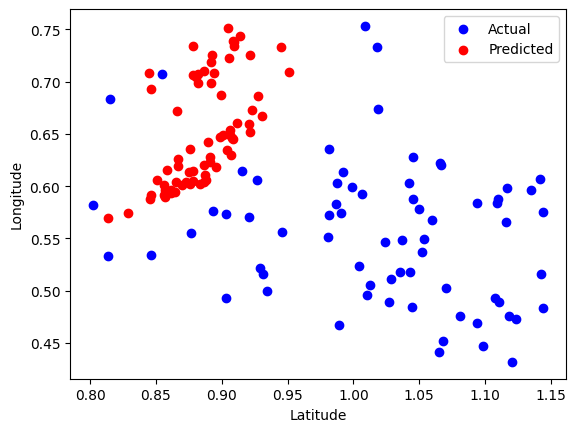

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.scatter(y_test[:, 0], y_test[:, 1], color='blue', label="Actual")
plt.scatter(y_pred[:, 0], y_pred[:, 1], color='red', label="Predicted")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.show()

In [ ]:
# Encode species as numerical values
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # Set sparse_output to False
season_encoded = encoder.fit_transform(df[["season"]])

df = df.drop(columns=["season"])
df[encoder.get_feature_names_out(["season"])] = season_encoded

# Select columns for normalization
features_to_normalize = ["temperature", "humidity", "wind_speed", "pressure", "distance_to_water"]
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

df

,datetime,latitude,longitude,month,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water,season_dry,season_rainy
44,2024-08-02 12:31:09,-2.254313,29.253315,8,0.564781,0.339891,0.705814,0.449632,12,1.224647e-16,-1.000000e+00,-0.866025,-0.5,0.427679,1.0,0.0
6,2024-08-02 13:36:57,-2.225643,29.224659,8,0.600297,0.231922,0.584596,0.654492,13,-2.588190e-01,-9.659258e-01,-0.866025,-0.5,0.319388,1.0,0.0
13,2024-08-04 21:20:42,-2.272969,29.241821,8,0.575505,0.058987,0.607937,0.907737,21,-7.071068e-01,7.071068e-01,-0.866025,-0.5,0.482437,1.0,0.0
38,2024-08-05 12:23:41,-2.274868,29.187846,8,0.929261,0.032992,0.420500,0.406055,12,1.224647e-16,-1.000000e+00,-0.866025,-0.5,0.479867,1.0,0.0
21,2024-08-05 15:56:22,-2.281515,29.309669,8,0.998687,0.366235,0.080548,0.718599,15,-7.071068e-01,-7.071068e-01,-0.866025,-0.5,0.565664,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,2025-02-26 18:56:14,-1.982661,29.397673,2,0.191589,0.997971,0.254541,0.179280,18,-1.000000e+00,-1.836970e-16,0.866025,0.5,0.170363,0.0,1.0
310,2025-02-27 12:12:50,-2.030966,29.420112,2,0.357585,0.883861,0.861948,0.461535,12,1.224647e-16,-1.000000e+00,0.866025,0.5,0.260828,0.0,1.0
349,2025-02-27 17:23:02,-2.028492,29.361984,2,0.119551,0.771830,0.336505,0.976931,17,-9.659258e-01,-2.588190e-01,0.866025,0.5,0.071001,0.0,1.0
317,2025-02-27 21:51:13,-2.014947,29.374930,2,0.111445,0.961164,0.281521,0.988088,21,-7.071068e-01,7.071068e-01,0.866025,0.5,0.103328,0.0,1.0


In [ ]:
train_df = df[df["month"] != 2]

test_df = df[df["month"] == 2]

train_df.drop(columns=["datetime", "month"], inplace=True)

test_df.drop(columns=["datetime", "month"], inplace=True)

train_df

<ipython-input-11-28dd164cd711>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["datetime", "month"], inplace=True)
<ipython-input-11-28dd164cd711>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=["datetime", "month"], inplace=True)


,latitude,longitude,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water,season_dry,season_rainy
44,-2.254313,29.253315,0.564781,0.339891,0.705814,0.449632,12,1.224647e-16,-1.000000,-0.866025,-0.500000,0.427679,1.0,0.0
6,-2.225643,29.224659,0.600297,0.231922,0.584596,0.654492,13,-2.588190e-01,-0.965926,-0.866025,-0.500000,0.319388,1.0,0.0
13,-2.272969,29.241821,0.575505,0.058987,0.607937,0.907737,21,-7.071068e-01,0.707107,-0.866025,-0.500000,0.482437,1.0,0.0
38,-2.274868,29.187846,0.929261,0.032992,0.420500,0.406055,12,1.224647e-16,-1.000000,-0.866025,-0.500000,0.479867,1.0,0.0
21,-2.281515,29.309669,0.998687,0.366235,0.080548,0.718599,15,-7.071068e-01,-0.707107,-0.866025,-0.500000,0.565664,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,-2.050206,29.413074,0.141503,0.869187,0.486797,0.863380,13,-2.588190e-01,-0.965926,0.500000,0.866025,0.254162,0.0,1.0
274,-2.045079,29.456578,0.267417,0.717436,0.798804,0.185464,17,-9.659258e-01,-0.258819,0.500000,0.866025,0.389314,0.0,1.0
295,-2.020212,29.470250,0.348118,0.788776,0.940859,0.390465,2,5.000000e-01,0.866025,0.500000,0.866025,0.419185,0.0,1.0
296,-2.057163,29.369083,0.379872,0.791638,0.248240,0.512930,3,7.071068e-01,0.707107,0.500000,0.866025,0.124718,0.0,1.0


In [ ]:
test_df

,latitude,longitude,temperature,humidity,wind_speed,pressure,hour,hour_sin,hour_cos,month_sin,month_cos,distance_to_water,season_dry,season_rainy
320,-1.997112,29.353395,0.066869,0.886003,0.317652,0.022961,8,8.660254e-01,-5.000000e-01,0.866025,0.5,0.024823,0.0,1.0
328,-2.032977,29.403417,0.273103,0.709361,0.273761,0.842123,11,2.588190e-01,-9.659258e-01,0.866025,0.5,0.208140,0.0,1.0
347,-2.039013,29.384034,0.111290,0.746300,0.046420,0.292548,13,-2.588190e-01,-9.659258e-01,0.866025,0.5,0.151032,0.0,1.0
311,-2.033821,29.379033,0.056867,0.843106,0.050384,0.709752,19,-9.659258e-01,2.588190e-01,0.866025,0.5,0.130322,0.0,1.0
333,-2.036493,29.367841,0.327645,0.958832,0.102028,0.095172,23,-2.588190e-01,9.659258e-01,0.866025,0.5,0.097096,0.0,1.0
307,-1.991197,29.354454,0.416817,0.703841,0.947666,0.948954,17,-9.659258e-01,-2.588190e-01,0.866025,0.5,0.027140,0.0,1.0
314,-2.011165,29.402314,0.318381,0.744904,0.401662,0.657435,6,1.000000e+00,6.123234e-17,0.866025,0.5,0.191435,0.0,1.0
342,-1.984091,29.369687,0.434693,0.887933,0.789278,0.544912,21,-7.071068e-01,7.071068e-01,0.866025,0.5,0.077331,0.0,1.0
346,-1.995046,29.400270,0.136793,0.865064,0.359459,0.007193,19,-9.659258e-01,2.588190e-01,0.866025,0.5,0.179823,0.0,1.0
302,-2.009239,29.386141,0.000022,0.974653,0.260635,0.233952,21,-7.071068e-01,7.071068e-01,0.866025,0.5,0.137317,0.0,1.0


In [ ]:
class WildlifeEnvironment:
    def __init__(self, data, convex_hulls):
        self.data = data
        self.convex_hulls = convex_hulls
        self.current_month = 5

    def reset(self):
        self.current_month = 5
        return self._get_state()

    def _get_state(self):
        # Return the state for the past 5 months
        state = self.data[self.current_month-5:self.current_month]
        return state

    def step(self, action):
        # Predict the convex hull for the next month
        predicted_hull = action
        actual_hull = self.convex_hulls[self.current_month + 1]

        # Calculate reward (IoU)
        reward = self._calculate_iou(predicted_hull, actual_hull)

        # Update the month
        self.current_month += 1

        # Check if the episode is done
        done = self.current_month >= len(self.data) - 1

        return self._get_state(), reward, done

    def _calculate_iou(self, hull1, hull2):
        # Calculate the Intersection over Union (IoU) between two convex hulls
        # (Implementation depends on your convex hull representation)
        pass

In [ ]:
from stable_baselines3 import PPO

# Initialize the environment
env = WildlifeEnvironment(train_df, convex_hulls)

# Initialize the RL agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

In [ ]:
custom_order = [8, 9, 10, 11, 12, 1, 2]

convex_hulls  = {i: convex_hulls[month] for i, month in enumerate(custom_order, start=1)}

convex_hulls

{1: array([[-2.30152601, 29.31037332],
        [-2.35353329, 29.22523703],
        [-2.32732966, 29.20175533],
        [-2.29227904, 29.18032843],
        [-2.27486791, 29.18784636],
        [-2.22358565, 29.21189591],
        [-2.20324159, 29.2255856 ],
        [-2.28151508, 29.30966867]]),
 2: array([[-2.24021551, 29.31326327],
        [-2.24633751, 29.26547698],
        [-2.23893232, 29.25857909],
        [-2.22983009, 29.25353443],
        [-2.19250639, 29.24556176],
        [-2.16670719, 29.24876341],
        [-2.1643822 , 29.2586608 ],
        [-2.16102838, 29.27316906],
        [-2.16446528, 29.29181411],
        [-2.18544831, 29.33240994],
        [-2.20345455, 29.33506008],
        [-2.22240186, 29.33267181]]),
 3: array([[-2.34678151, 29.4524128 ],
        [-2.34103396, 29.41960355],
        [-2.31758732, 29.39232226],
        [-2.29527498, 29.37027027],
        [-2.24891559, 29.37468769],
        [-2.23236229, 29.39401301],
        [-2.21236493, 29.43251943],
        [-2.196

In [ ]:
month_to_cyclical = {
    month: (
        np.sin(2 * np.pi * (month - 1) / 12),  # month_sin
        np.cos(2 * np.pi * (month - 1) / 12)   # month_cos
    )
    for month in custom_order
}

# Create a reverse mapping from cyclical features to month
cyclical_to_month = {v: k for k, v in month_to_cyclical.items()}

cyclical_to_month

{(-0.4999999999999997, -0.8660254037844388): 8,
 (-0.8660254037844384, -0.5000000000000004): 9,
 (-1.0, -1.8369701987210297e-16): 10,
 (-0.8660254037844386, 0.5000000000000001): 11,
 (-0.5000000000000004, 0.8660254037844384): 12,
 (0.0, 1.0): 1,
 (0.49999999999999994, 0.8660254037844387): 2}

In [ ]:
cyclical_to_month = {(-0.4999999999999997, -0.8660254037844388): 8,
 (-0.8660254037844384, -0.5000000000000004): 9,
 (-1.0, -1.8369701987210297e-16): 10,
 (-0.8660254037844386, 0.5000000000000001): 11,
 (-0.5000000000000004, 0.8660254037844384): 12,
 (0.0, 1.0): 1,}

test_month = {(0.49999999999999994, 0.8660254037844387): 2}

In [ ]:
train_convex_hulls = {k: v for k, v in convex_hulls.items() if k != 7}
test_convex_hull = convex_hulls[7]

test_convex_hull

array([[-1.97720107, 29.3987887 ],
       [-2.02287327, 29.43215729],
       [-2.02332004, 29.43180978],
       [-2.03096556, 29.42011222],
       [-2.04216628, 29.39895155],
       [-2.05318159, 29.3765291 ],
       [-2.03729697, 29.36539215],
       [-1.98951305, 29.34634294],
       [-1.9809469 , 29.34921497],
       [-1.97908606, 29.36560886]])

In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from geopy.distance import geodesic

In [ ]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from stable_baselines3 import PPO
from geopy.distance import geodesic

class WildlifeEnvironment(gym.Env):  # Inherit from gym.Env
    def __init__(self, data, convex_hulls, custom_month_order, cyclical_to_month):
        super().__init__()  # Call the superclass constructor
        self.data = data
        # Align convex_hulls keys with custom_month_order
        self.convex_hulls = {i: convex_hulls[month] for i, month in enumerate(custom_month_order, start=1)}
        self.custom_month_order = custom_month_order
        self.cyclical_to_month = cyclical_to_month
        self.current_index = 0  # Start with the first month in the custom order

        # Determine the observation space shape dynamically
        sample_state = self._get_state()  # Get a sample state
        state_shape = sample_state.shape  # Get the shape of the state

        # Define observation and action spaces
        self.observation_space = spaces.Box(low=0, high=1, shape=state_shape, dtype=np.float32)
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Adjust if necessary

    def reset(self):
        self.current_index = 0
        return self._get_state()

    def _get_state(self):
        # Get the current month based on the custom order
        current_month = self.custom_month_order[self.current_index]

        # Return the state for the past 5 months
        state = self.data[
            (self.data["month_sin"] == month_to_cyclical[current_month][0]) &
            (self.data["month_cos"] == month_to_cyclical[current_month][1])
        ]

        # Check if the state is empty, if so, return a default state
        if state.empty:
            state = self.data.iloc[0]  # Return the first row as default
            state = state.values  # Return the underlying NumPy array
        else:
            state = state.values

        print("state shape: ", state.shape)  # Check the shape of the state

        return state  # Return the underlying NumPy array

    def step(self, action):
        # Predict the convex hull for the next month
        predicted_hull = action

        # Get the next month in the custom order
        next_index = (self.current_index + 1) % len(self.custom_month_order)
        next_month_index_in_custom_order = (self.current_index + 1) % len(self.custom_month_order) # get index, not month value
        next_month = self.custom_month_order[next_month_index_in_custom_order]

        # Get the actual convex hull for the next month using next_month_index_in_custom_order + 1 as key
        # Check if the next month index + 1 is within the bounds of convex_hulls keys
        if next_month_index_in_custom_order + 1 in self.convex_hulls:
            actual_hull = self.convex_hulls[next_month_index_in_custom_order + 1]
        else:
            # If not, reset to the beginning (key 1)
            self.reset()
            actual_hull = self.convex_hulls[1]  # Use the first month's hull (key 1)
            print(f"Warning: Month {next_month} not found in convex_hulls. Resetting environment.")

        # Calculate reward (IoU - you need to implement this)
        reward = self._calculate_iou(predicted_hull, actual_hull)  # Ensure this returns a numerical value

        # Update the month
        self.current_index = next_index  # Move to the next month

        # Check if the episode is done
        done = self.current_index == len(self.custom_month_order) - 1  # Episode is done when all months are processed

        # Dummy truncated and info
        truncated = False
        info = {}

        # Return the next state, reward, done, and info
        return self._get_state(), reward, done, truncated, info

    def _calculate_iou(self, hull1, hull2):
        # Calculate the Intersection over Union (IoU) between two convex hulls
        # (Implementation depends on your convex hull representation)
        # This is a placeholder, replace with your actual IoU calculation
        # For example, if your hulls are represented as shapely Polygons:
        # from shapely.geometry import Polygon
        # polygon1 = Polygon(hull1)
        # polygon2 = Polygon(hull2)
        # iou = polygon1.intersection(polygon2).area / polygon1.union(polygon2).area
        # return iou
        return 0  # Placeholder, replace with actual calculation

In [ ]:
!pip install shimmy>=2.0

In [ ]:
from stable_baselines3 import PPO


custom_order = [8, 9, 10, 11, 12, 1]

# Initialize the environment with the training convex hulls
env = WildlifeEnvironment(train_df, train_convex_hulls, custom_order, cyclical_to_month)

# Initialize the RL agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

KeyError: 8

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(5, num_features)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Scatter plot of actual vs predicted locations
plt.scatter(y_test[:, 0], y_test[:, 1], label="Actual", color='blue')
plt.scatter(y_pred[:, 0], y_pred[:, 1], label="Predicted", color='red')

# Compute Convex Hull
hull = ConvexHull(y_test)
for simplex in hull.simplices:
    plt.plot(y_test[simplex, 0], y_test[simplex, 1], 'k-')

plt.legend()
plt.show()